##  This notebook is specifically for the datasets with NO detailed job description.
Every night at 1am
Scrape data from Indeed to create 3 csv datasets based on:
'data science data scientist' 
'data analyst data analytics'
'machine learning'

In [2265]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from library.sb_utils import save_file

today = datetime.today().strftime('%Y_%m_%d')
dfNames=['da','ds','ml','ai']

list_of_df = []
data = pd.DataFrame()


for n in dfNames:
    fileName = '../data/raw/{0}_last{1}d_R_{2}.csv'.format(n,'1', today)
    df = pd.read_csv(fileName, skiprows=[0])
    print(df.shape)
    
    #will be deleted after first couple of trials
    list_of_df.append(df)
    
    #combine 3 files together
    data = data.append(df, ignore_index=True)
    print(data.shape)


(679, 13)
(679, 13)
(1003, 13)
(1682, 13)
(1008, 13)
(2690, 13)
(909, 13)
(3599, 13)


In [2266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599 entries, 0 to 3598
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JobID           3599 non-null   object 
 1   JobTitle        3599 non-null   object 
 2   Company         3599 non-null   object 
 3   Location        3599 non-null   object 
 4   CompanyRating   3017 non-null   float64
 5   PostDate        3599 non-null   object 
 6   ExtractDate     3599 non-null   object 
 7   Summary         3599 non-null   object 
 8   Salary          550 non-null    object 
 9   Remote          701 non-null    object 
 10  JobUrl          3599 non-null   object 
 11  JobDetail       382 non-null    object 
 12  JobDescription  723 non-null    object 
dtypes: float64(1), object(12)
memory usage: 365.6+ KB


In [2267]:
# To confirm the necessity of the step of de-duping the combined daily file. 
id_0 = set(list_of_df[0].JobID)
id_1 = set(list_of_df[1].JobID)
id_2 = set(list_of_df[2].JobID)
id_3 = set(list_of_df[3].JobID)

In [2268]:
print(len(id_0.intersection(id_1)))
print(len(id_0.intersection(id_2)))
print(len(id_0.intersection(id_3)))
print(len(id_1.intersection(id_2)))
print(len(id_1.intersection(id_3)))
print(len(id_2.intersection(id_3)))

101
34
16
473
415
342


### Step 1: De - duplicate records with same JobID
There are overlaps after combining 3 files together


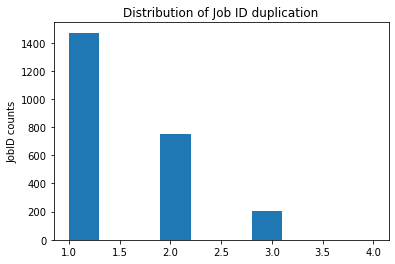

In [2269]:
data.JobID.value_counts().plot(kind='hist')
plt.title('Distribution of Job ID duplication')
plt.ylabel('JobID counts')
plt.xlabel('')
plt.show()

In [2270]:
#Group by column having count > 1 
#data.groupby('JobID').filter(lambda x: len(x) >1 ).sort_values('JobID')

In [2271]:
data.JobID.describe()

count                 3599
unique                2430
top       0870b7869deb3936
freq                     4
Name: JobID, dtype: object

In [2272]:
# To de-dup the records in the combined file
data.drop_duplicates(subset = 'JobID', inplace= True)
data.JobID.describe()

count                 2430
unique                2430
top       ecc9f46537a988fd
freq                     1
Name: JobID, dtype: object

In [2273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 0 to 3598
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   JobID           2430 non-null   object 
 1   JobTitle        2430 non-null   object 
 2   Company         2430 non-null   object 
 3   Location        2430 non-null   object 
 4   CompanyRating   1972 non-null   float64
 5   PostDate        2430 non-null   object 
 6   ExtractDate     2430 non-null   object 
 7   Summary         2430 non-null   object 
 8   Salary          391 non-null    object 
 9   Remote          468 non-null    object 
 10  JobUrl          2430 non-null   object 
 11  JobDetail       242 non-null    object 
 12  JobDescription  481 non-null    object 
dtypes: float64(1), object(12)
memory usage: 265.8+ KB


In [2274]:
# To reindex 
data.index = np.arange(0,len(data))

### Step 2: Create a new variable 'DatePosted' as the exact date of job posted

In [2275]:
data.PostDate.unique()

array(['Today', 'Just posted', '1 day ago'], dtype=object)

In [2276]:
data.PostDate.str.contains('ago').sum()

138

In [2277]:
'|'.join(['ago','day','days'])

'ago|day|days'

In [2278]:
# To create a new variable 'DatePosted' by remove the string from 'PostDate' and convert to int
data['DatePosted'] = data.PostDate.str.replace('day ago|days ago','').str.replace('Today|Just posted','0').str.strip().astype(int)

In [2279]:
data.DatePosted.unique()

array([0, 1])

In [2280]:
data.DatePosted.dtypes

dtype('int32')

In [2281]:
# To convert 'ExtractDate' to datetime type
data['ExtractDate'] = pd.to_datetime(data['ExtractDate'])

In [2282]:
# To Convert 'DatePosted' from int to timeDelta type and compute the exact date when the job was posted 
data.DatePosted = pd.to_timedelta(data.DatePosted, unit='D')
data.DatePosted = pd.to_datetime(data['ExtractDate'] - data['DatePosted'])


In [2283]:
data.loc[:,['PostDate','ExtractDate','DatePosted']]

,PostDate,ExtractDate,DatePosted
0,Today,2021-02-23,2021-02-23
1,Today,2021-02-23,2021-02-23
2,Today,2021-02-23,2021-02-23
3,Today,2021-02-23,2021-02-23
4,Just posted,2021-02-23,2021-02-23
...,...,...,...
2425,Today,2021-02-23,2021-02-23
2426,Today,2021-02-23,2021-02-23
2427,Today,2021-02-23,2021-02-23
2428,Today,2021-02-23,2021-02-23


### Step 3: Create a new variable 'isRemote' and assign boolean value based on varible 'Remote' OR 'Location'

In [2255]:
data.Remote.unique()

array(['Temporarily remote', nan, 'Remote'], dtype=object)

In [2256]:
data.Remote.describe()

count        468
unique         2
top       Remote
freq         359
Name: Remote, dtype: object

In [2294]:
# Work on the contingency table (pivot talbe) between Location and Remote
s_Location = data.Location.copy()
s_Location[s_Location != 'Remote'] = 'Others'
s_Location.describe()

count       2430
unique         2
top       Others
freq        2308
Name: Location, dtype: object

In [2295]:
s_Remote = data.Remote.copy()
s_Remote[s_Remote != 'Remote'] = 'Others'
s_Remote.describe()

pd.crosstab(s_Location, s_Remote)

Remote,Others,Remote
Location,,
Others,1949,359
Remote,122,0


In [2296]:
data.Remote.unique()

array(['Temporarily remote', nan, 'Remote'], dtype=object)

In [2302]:
# try to construct contingency table directly from dataframe using groupby
#[('Others' if (l!='Remote') else l, 'Others' if (r!='Remote') else r )   for l,r in data['Location','Remote']]  #.groupby(by =['Location', 'Remote']).agg('count')

In [2303]:
data.Location.str.contains('Remote').sum()

122

In [2304]:
(data.Location =='Remote').sum()

122

In [2305]:
# To assign the value of Remote to the variable 'Remote' if the value of location is 'Remote'
# It maynot be necessary since we not going to use varialbe 'Remote' later
#data.loc[data.Location.str.contains('Remote'),'Remote'] = 'Remote'

In [2306]:
(data.Remote == 'Remote') | (data.Location =='Remote')

0       False
1        True
2        True
3        True
4        True
        ...  
2425    False
2426    False
2427    False
2428    False
2429    False
Length: 2430, dtype: bool

In [2309]:
# To create a new boolean variable 'isRemote' and assign Ture if varible 'Remote' OR 'Location' is Remote
data['isRemote'] = (data.Remote == 'Remote') | (data.Location =='Remote')
data.isRemote.describe()

count      2430
unique        2
top       False
freq       1949
Name: isRemote, dtype: object

### Step 4: Extract city, state information from Location, Create new variables 'City', ‘State', and 'Region' 


In [2310]:
data.Location.describe()

count       2430
unique       509
top       Remote
freq         122
Name: Location, dtype: object

In [2311]:
# To create two new variables City and State
newDf = data.Location.str.split(pat =',',expand =True)
data['City'] = newDf[0]
data['State'] = newDf[1]

In [2312]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 0 to 2429
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   JobID           2430 non-null   object        
 1   JobTitle        2430 non-null   object        
 2   Company         2430 non-null   object        
 3   Location        2430 non-null   object        
 4   CompanyRating   1972 non-null   float64       
 5   PostDate        2430 non-null   object        
 6   ExtractDate     2430 non-null   datetime64[ns]
 7   Summary         2430 non-null   object        
 8   Salary          391 non-null    object        
 9   Remote          468 non-null    object        
 10  JobUrl          2430 non-null   object        
 11  JobDetail       242 non-null    object        
 12  JobDescription  481 non-null    object        
 13  DatePosted      2430 non-null   datetime64[ns]
 14  isRemote        2430 non-null   bool          
 15  City

In [2313]:
# To clean up values of City ???? whether to treat special case 'United States' as Remote as well????
data.loc[data.City == 'Remote', 'City'] = np.nan
data.loc[data.City == 'United States', 'City'] = np.nan

In [2314]:
assert data.City.str.contains('Remote|United States').any()  == False

In [2315]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [2316]:
data.loc[((data.State.isnull()) & (~data.City.isnull())), 'City']


91          New Jersey
95          California
104            Florida
114             Oregon
149         New Jersey
             ...      
2218              Ohio
2235    New York State
2296     Massachusetts
2310     Massachusetts
2314     Massachusetts
Name: City, Length: 222, dtype: object

In [2317]:
# To fill the missing value of 'State' from 'City' for those which has only location of State 
data.State.fillna(data.City, inplace=True)

In [2318]:
# To clean up value of City
data.loc[data.State == data.City, 'City'] = np.nan

In [2319]:
data.State.unique()

array([' TN', nan, ' AZ', ' MO', ' NC', ' GA', ' DE', ' NJ', ' CA', ' DC',
       ' IL', ' VA', ' MA', ' AL', ' CT', ' TX', ' PA', ' NY', ' MI',
       ' OH', ' IA', ' MD', ' AK', ' CO', ' WA', ' FL', ' KY',
       'New Jersey', 'California', ' NE', ' IN', 'Florida', 'Oregon',
       ' MN', ' UT', 'Maryland', 'Connecticut', ' OK', ' SC', ' KS',
       ' NH', ' NV', ' MS', ' WI', ' WV', 'Texas', ' WY', 'Illinois',
       'Georgia', ' AR', ' OR', 'Missouri', 'North Carolina', 'Minnesota',
       'Pennsylvania', 'Massachusetts', 'Michigan', ' ID', ' NM', ' ME',
       'Wyoming', 'Nevada', 'Colorado', 'Oklahoma', 'West Virginia',
       'Arkansas', 'Alabama', 'North Dakota', 'Idaho', 'Ohio', ' LA',
       'Vermont', ' RI', 'Montana', 'New Mexico', 'Washington State',
       'Rhode Island', 'Virginia', 'Wisconsin', 'Delaware', 'Louisiana',
       'New Hampshire', 'Indiana', 'Kansas', 'Mississippi',
       'South Carolina', 'Arizona', ' SD', 'Nebraska', 'Kentucky', 'Iowa',
       'Utah', 'Te

In [2320]:
# To extract State abbrevation value from City variables to fill those missing values into 'State'
data.loc[data.State.str.len() >3,'State']=data.loc[data.State.str.len() >3,'State'].str.replace(' State','').map(us_state_abbrev)



In [2321]:
# To clean up the State values
data.State= data.State.str.strip()

In [2322]:
data.loc[:,['Location','City','State']]

,Location,City,State
0,"Nashville, TN",Nashville,TN
1,Remote,NaN,NaN
2,"Chandler, AZ",Chandler,AZ
3,"St. Louis, MO",St. Louis,MO
4,Remote,NaN,NaN
...,...,...,...
2425,"Chandler, AZ",Chandler,AZ
2426,"Irving, TX",Irving,TX
2427,"Minneapolis, MN",Minneapolis,MN
2428,"Woburn, MA",Woburn,MA


In [2323]:
# To cleaning up the value of 'Washington DC' on variable 'City'
data.loc[(data.City == 'Washington') & (data.State == 'DC'), 'City'] ='DC'

In [2324]:
# special cases "New York, NY"
data.loc[data.City.isin(us_state_abbrev.keys()), ['Location','City','State']]

,Location,City,State
38,"New York, NY",New York,NY
45,"New York, NY",New York,NY
56,"New York, NY",New York,NY
78,"New York, NY",New York,NY
105,"New York, NY",New York,NY
...,...,...,...
2194,"New York, NY",New York,NY
2213,"New York, NY",New York,NY
2329,"New York, NY",New York,NY
2334,"New York, NY",New York,NY


In [2325]:
data.State.unique()

array(['TN', nan, 'AZ', 'MO', 'NC', 'GA', 'DE', 'NJ', 'CA', 'DC', 'IL',
       'VA', 'MA', 'AL', 'CT', 'TX', 'PA', 'NY', 'MI', 'OH', 'IA', 'MD',
       'AK', 'CO', 'WA', 'FL', 'KY', 'NE', 'IN', 'OR', 'MN', 'UT', 'OK',
       'SC', 'KS', 'NH', 'NV', 'MS', 'WI', 'WV', 'WY', 'AR', 'ID', 'NM',
       'ME', 'ND', 'LA', 'VT', 'RI', 'MT', 'SD', 'HI', 'PR'], dtype=object)

In [2326]:
# To categorize state value into 4 regions 
us_state_regions = {
    'Alabama': 'South',
    'Alaska': 'West',
    'American Samoa': 'Islands',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'South',
    'District of Columbia': 'South',
    'Florida': 'South',
    'Georgia': 'South',
    'Guam': 'Islands',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'South',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'South',
    'North Dakota': 'Midwest',
    'Northern Mariana Islands':'Islands',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Puerto Rico': 'Islands',
    'Rhode Island': 'Northeast',
    'South Carolina': 'South',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virgin Islands': 'Islands',
    'Virginia': 'South',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

In [2327]:
us_state_regions_mapping =  {v: us_state_regions[k] for k, v in us_state_abbrev.items()}

In [2328]:
# To create a new variable 'Region' by mapping to the dict
data['Region'] = data.loc[~data.State.isnull(),'State'].map(us_state_regions_mapping).astype('category')

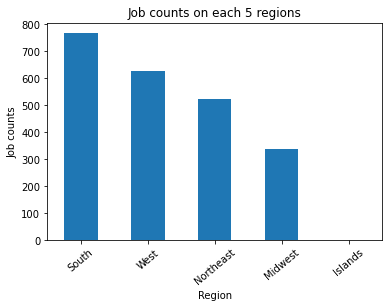

In [2330]:
data.Region.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('Region')
plt.xticks(rotation=40)
plt.title('Job counts on each 5 regions')
plt.show()

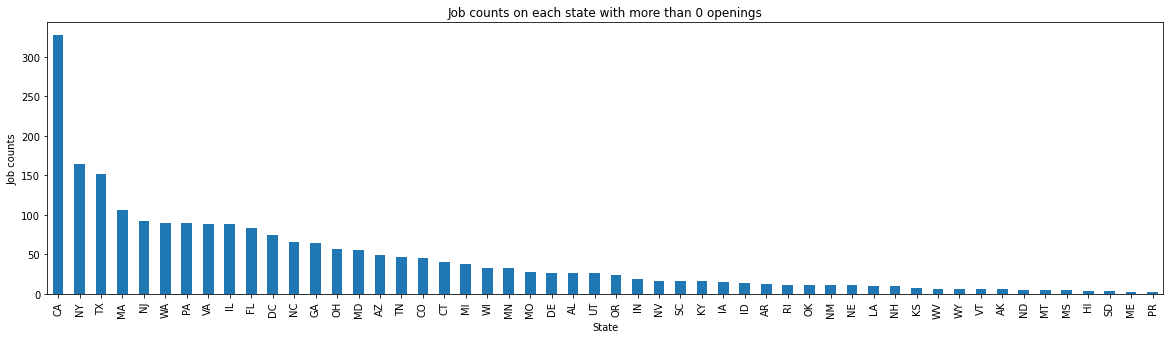

In [2331]:
plt.subplots(figsize=(20, 5))
data.State.value_counts().plot(kind='bar')
plt.ylabel('Job counts')
plt.xlabel('State')
plt.title('Job counts on each state with more than 0 openings')
plt.show()

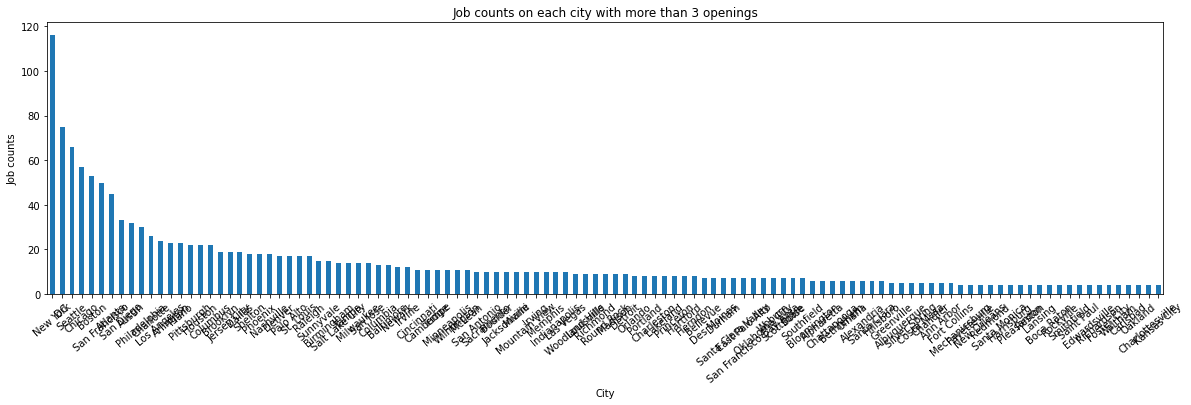

In [2332]:
plt.subplots(figsize=(20, 5))
data.groupby('City').filter(lambda x: len(x) >3 )['City'].value_counts().plot(kind='bar')
plt.xticks(rotation=40)
plt.ylabel('Job counts')
plt.xlabel('City')
plt.title('Job counts on each city with more than 3 openings')
plt.show()     

In [2333]:
data.City.str.contains('Princeton').sum()

8

### Step 5: Create new variables 'isSenior', 'isJunior', and 'isMid' from job Title

In [2334]:
data.JobTitle.unique()

array(['Data Analyst', 'Principal Business Analyst, Broker Compensation',
       'REMOTE Data Analyst (BHJOB1435_25995) DH', ...,
       'Graph Analytics Research Lead',
       'Lead Application Engineer - .NET',
       'Lead Software Engineer- Analysis & Decision Systems'],
      dtype=object)

In [2335]:
# these may not be necessary
#data['JobTitle'] = data['JobTitle'].astype('str')
#type(data.JobTitle[0])

In [2336]:
data['isSenior'] = data.JobTitle.str.contains('Senior|Sr|sr|Director|VP|Lead|Principal')

In [2337]:
data['isJunior'] = data.JobTitle.str.contains('Junior|Jr|jr|Intern')

In [2338]:
data['isMid'] = data.JobTitle.str.contains('Mid Level|Mid-')

In [2339]:
data.loc[:, ['JobTitle','isSenior','isJunior','isMid']].head(3)

,JobTitle,isSenior,isJunior,isMid
0,Data Analyst,False,False,False
1,"Principal Business Analyst, Broker Compensation",True,False,False
2,REMOTE Data Analyst (BHJOB1435_25995) DH,False,False,False


In [2340]:
data[data.JobTitle.str.contains('Mid Level|Mid-')]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,JobDetail,JobDescription,DatePosted,isRemote,City,State,Region,isSenior,isJunior,isMid


### Step 6: Process Salary data, and create new variables SalaryMidValue and SalaryGroup 

In [2341]:
# string, dict, list appear as Object in df, however, the type can be tested as individual cell
# data.Salary = data.Salary.astype(str) # this cause missing value from NaN to 'nan'
type(data.Salary[0])


str

In [2342]:
# the $ that prevents the substring to be found
data.Salary.str.contains('103,690 ').sum()

7

In [2350]:
data.loc[(data.Salary =='$103,690 - $134,798 a year') & (data.isRemote), 'JobDescription']#.iloc[0]

377    Duties\nSummary\nAs our nation navigates the C...
659    Duties\nSummary\nA successful candidate in thi...
Name: JobDescription, dtype: object

In [2351]:
data.Salary.unique()

array(['$70,000 - $80,000 a year', '$121,700 a year', '$24 - $25 an hour',
       '$40 - $45 an hour', nan, '$68,292 - $143,403 a year',
       '$22 - $25 an hour', '$85,000 - $178,393 a year',
       'Up to $80,000 a year', '$31 - $33 an hour', '$27 - $33 an hour',
       '$100,000 - $105,000 a year', '$167,000 - $301,000 a year',
       '$55 - $65 an hour', '$13 an hour', '$93,000 - $113,000 a year',
       '$65,000 - $75,000 a year', '$61,100 - $101,000 a year',
       '$50,000 - $56,000 a year', '$65,000 - $90,000 a year',
       '$5,000 - $6,833 a month', '$56,736 - $128,001 a year',
       '$50,000 a year', '$85,000 - $100,000 a year',
       '$80,000 - $110,000 a year', '$45 - $50 an hour',
       '$65,000 - $70,000 a year', '$35,000 a year',
       '$6,608 - $14,808 a month', '$71,137 - $118,397 a year',
       '$49,296 - $64,848 a year', '$50,000 - $60,000 a year',
       'Up to $60,000 a year', 'From $35 an hour',
       '$13.46 - $17.31 an hour', '$40 - $50 an hour',
       

In [2352]:
# To create a new variable 'SalaryUnit'
data['SalaryUnit'] = data.Salary.str.extract('(an hour|a year|a month|a week|per class|a day)', expand = True)
data['SalaryUnit'].unique()

array(['a year', 'an hour', nan, 'a month'], dtype=object)

In [2353]:
# To create a new variable 'SalaryMidValue' going to contain the mid point value for the arrange of salary
data['SalaryMidValue'] = data['Salary'].str.replace('an hour|a year|a month|a week|per class|a day','').str.replace('$','').str.replace(',','')
#data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(40)

In [2354]:
# Set busniss rule to treat range 
# Ignore 'Up to' and 'From' 
data['SalaryMidValue'] = data.SalaryMidValue.str.replace('Up to|From','').str.strip()
#data.SalaryMidValue.unique()

In [2355]:
# Take mid value for range salary
s_df = data.SalaryMidValue.str.split(pat ='-',expand =True)
s_df[1].fillna(s_df[0], inplace=True)

data['SalaryMidValue']  = (s_df[1].astype(float)+s_df[0].astype(float))/2


In [2356]:
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue']].head(4)

,Salary,SalaryUnit,SalaryMidValue
0,"$70,000 - $80,000 a year",a year,75000.0
1,"$121,700 a year",a year,121700.0
2,$24 - $25 an hour,an hour,24.5
3,$40 - $45 an hour,an hour,42.5


In [2357]:
# Convert hourly rate to Salary based on formula hr * 40 * 52 
data.loc[data.SalaryUnit.str.contains('hour', na=False),'SalaryMidValue'] = data.SalaryMidValue * 40 * 52

In [2358]:
# Convert monthly rate to Salary based on formula mr * 12
data.loc[data.SalaryUnit.str.contains('month', na=False),'SalaryMidValue'] = data.SalaryMidValue * 12

In [2359]:
# Convert weekly rate to Salary based on fomula wr * 52 
data.loc[data.SalaryUnit.str.contains('week', na = False), 'SalaryMidValue'] =data.SalaryMidValue * 52

In [2360]:
# Convert daily rate to Salary based on formula dr * 5 * 52
data.loc[data.SalaryUnit.str.contains('day', na=False),'SalaryMidValue'] = data.SalaryMidValue * 5 * 52

In [2361]:
# Ignore the teaching job
data.loc[data.SalaryUnit.str.contains('class', na=False),'SalaryMidValue'] = np.nan

In [2362]:
data.SalaryMidValue.describe()

count       391.000000
mean      96747.515857
std       48152.210754
min       27040.000000
25%       62400.000000
50%       81731.500000
75%      119716.250000
max      234000.000000
Name: SalaryMidValue, dtype: float64

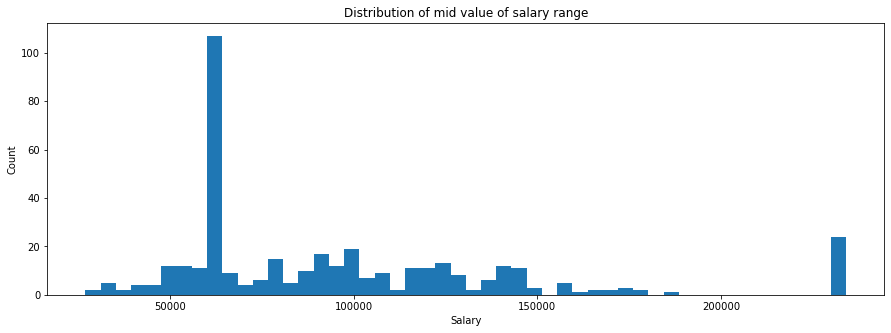

In [2363]:
plt.subplots(figsize = (15,5))
data.SalaryMidValue.plot(kind='hist', bins=50)
plt.xlabel('Salary')
plt.ylabel('Count')
plt.title('Distribution of mid value of salary range')
plt.show()

In [2364]:
# Create SalaryGroup for SalaryMidValue variable
salaryGroupLabels = ['20K-50K','50K-75k','75k-100k','100k-125k','125k+']
salaryRanges =[20000, 50000, 75000, 100000, 125000, np.inf]
data['SalaryGroup'] = pd.cut(data.SalaryMidValue, bins = salaryRanges, labels = salaryGroupLabels)
#data['SalaryGroup'] = pd.qcut(data.SalaryMidValue, q=5, labels = salaryGroupLabels)
data.loc[~data.Salary.isnull(),['Salary','SalaryUnit','SalaryMidValue','SalaryGroup']].head()

,Salary,SalaryUnit,SalaryMidValue,SalaryGroup
0,"$70,000 - $80,000 a year",a year,75000.0,50K-75k
1,"$121,700 a year",a year,121700.0,100k-125k
2,$24 - $25 an hour,an hour,50960.0,50K-75k
3,$40 - $45 an hour,an hour,88400.0,75k-100k
12,"$68,292 - $143,403 a year",a year,105847.5,100k-125k


In [2365]:
data.SalaryGroup.value_counts().sort_index()

20K-50K       27
50K-75k      151
75k-100k      77
100k-125k     54
125k+         82
Name: SalaryGroup, dtype: int64

In [2366]:
((data.SalaryMidValue <= 125000) & (data.SalaryMidValue > 100000)).sum()

54

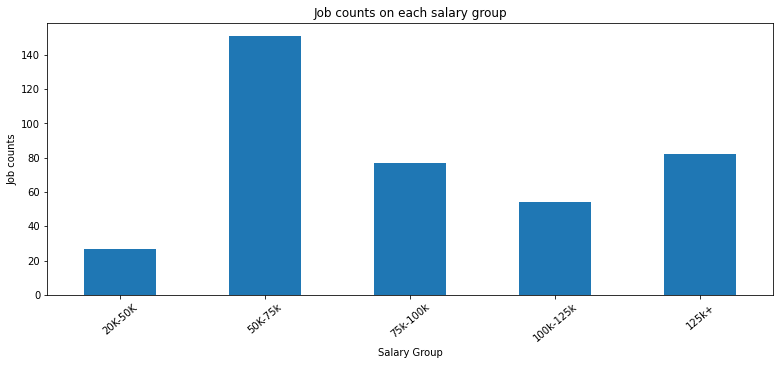

In [2367]:
plt.subplots(figsize=(13,5))
data.SalaryGroup.value_counts(sort=False).plot(kind='bar')
plt.xticks(rotation =40)
plt.xlabel('Salary Group')
plt.ylabel('Job counts')
plt.title('Job counts on each salary group')
plt.show()

In [2368]:
assert data.SalaryMidValue.min() > 10000  

In [2369]:
(data.SalaryMidValue < 100000).sum()

251

In [2370]:
data.SalaryMidValue.isnull().sum()

2039

### Step 7: Create varibles 'Industry' and 'Skillsets' and extract information from 'JobDescription'

In [2371]:
data.JobDescription.str.contains('pandas').sum()

7

### Pandas profiling 

In [2372]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2373]:
# uncomment and run below if you need to pip install the pandas-profiling library
#import sys
#!{sys.executable} -m pip install -U pandas-profiling==2.9.0
#!jupyter nbextension enable --py widgetsnbextension

In [2374]:
from pathlib import Path

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

In [2375]:
report = data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)
report

In [2376]:
profile_report = data.profile_report(html={'style': {'full_width': True}})
profile_report.to_file("../reports/pandas_profiling/{0}_daily.html".format(today))

In [2377]:
#To do list: 
# check missing state  : done ! 
# categorize state: done !
# check dup id : done ! 
# salay categorizing : done!
# remove unneeded columns, save in the interim folder: done!
# run today's data without dedup line in the data collection loop:   done!
# run 2021_02_17 again to fix monthly salary data error: not necessary, since we may not using those data.  done!
# To check detailed description with np.nan value: done!
# make library using package: add project path to sys.path done!

# put it together after a week of trials: 
# find a better way to split Location, to auto treat the case which only contains state information but not ','???
# To check the result with new search string in use for more relevence, especially look for salary data: done! 
# with incomplete data set with ML, the lowest salary is increased to 33000, which support our keyword search modification.
# tomorrow will check 



# Job Title: not for cleaning stage but later for EDA.  
# company frequency - company rating : not for cleaning stage but later for EDA. 
# location: not for cleaning stage but later for EDA. 

# Note:
# 1: some big companies could have up to two digits job posting within one day. I can dive deep into analysis on specific 
# company 
# 2: may consider not including data analyst or analytics, ...tried without ','

In [2378]:
data.State.unique()

array(['TN', nan, 'AZ', 'MO', 'NC', 'GA', 'DE', 'NJ', 'CA', 'DC', 'IL',
       'VA', 'MA', 'AL', 'CT', 'TX', 'PA', 'NY', 'MI', 'OH', 'IA', 'MD',
       'AK', 'CO', 'WA', 'FL', 'KY', 'NE', 'IN', 'OR', 'MN', 'UT', 'OK',
       'SC', 'KS', 'NH', 'NV', 'MS', 'WI', 'WV', 'WY', 'AR', 'ID', 'NM',
       'ME', 'ND', 'LA', 'VT', 'RI', 'MT', 'SD', 'HI', 'PR'], dtype=object)

In [2379]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2430 entries, 0 to 2429
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   JobID           2430 non-null   object        
 1   JobTitle        2430 non-null   object        
 2   Company         2430 non-null   object        
 3   Location        2430 non-null   object        
 4   CompanyRating   1972 non-null   float64       
 5   PostDate        2430 non-null   object        
 6   ExtractDate     2430 non-null   datetime64[ns]
 7   Summary         2430 non-null   object        
 8   Salary          391 non-null    object        
 9   Remote          468 non-null    object        
 10  JobUrl          2430 non-null   object        
 11  JobDetail       242 non-null    object        
 12  JobDescription  481 non-null    object        
 13  DatePosted      2430 non-null   datetime64[ns]
 14  isRemote        2430 non-null   bool          
 15  City

### Save the dataset in interim folder

In [2380]:
data.shape

(2430, 24)

In [2381]:
# Drop few columns not needed for further analysis
s_data = data.drop(columns = ['PostDate','ExtractDate','Salary', 'SalaryUnit','Remote', 'JobUrl'])

In [2382]:
s_data.shape

(2430, 18)

In [2408]:
# Add project path
import os
import sys
parent_project_path = os.path.abspath(os.path.join('..'))
if parent_project_path not in sys.path:
    sys.path.append(parent_project_path)


In [2410]:
# save the data to a new csv file

from src.library.sb_utils import save_file
datapath = '../data/interim/'
fileName = '{0}_daily.csv'.format(today)
save_file(s_data, fileName, datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)n

Please re-run this cell with a new filename.


In [2390]:
set(data.loc[data.Company.str.contains('Amazon Dev Center U.S., Inc.',na=False),'JobID']).intersection(id_3)

{'0c1c1fb03d034642',
 '250fac673af5d56e',
 '794a4a69e78081ea',
 '891a32bad15ed2aa',
 'd2512be3e3e13d3b',
 'd5cdf793ad8fbfc0',
 'e0165c707517e063'}

In [2393]:
data.loc[(data.Company.str.contains('Pearson',na=False)) & (data.State == 'NJ')]

,JobID,JobTitle,Company,Location,CompanyRating,PostDate,ExtractDate,Summary,Salary,Remote,...,isRemote,City,State,Region,isSenior,isJunior,isMid,SalaryUnit,SalaryMidValue,SalaryGroup
717,5e3b70eb162c8ef6,Intern - Machine Learning Quality Engineer,Pearson,"Trenton, NJ",3.8,Today,2021-02-23,Previous project work in using or presenting q...,$30 an hour,Remote,...,True,Trenton,NJ,Northeast,False,True,False,an hour,62400.0,50K-75k
1607,778e272e21c48a3a,Intern - Software Systems Engineer,Pearson,"Trenton, NJ",3.8,Today,2021-02-23,Leverage AWS machine learning and Artificial I...,$30 an hour,Remote,...,True,Trenton,NJ,Northeast,False,True,False,an hour,62400.0,50K-75k
